# INF-510 Homework 3

> Francisco Casas Barrientos

> franciscojacb@gmail.com

> 201373001-9

In [1]:
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.collections as clt
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate
import scipy.linalg

In [2]:
# Waterfall diagram
def waterfall(xs,zs,data,maxlines=300,spacial2d=False,elev=60,azim=180+75,title=None,**args):
    xs = np.array(xs)
    zs = np.array(zs)
    data = np.array(data)
    
    step = (zs.size+maxlines-1)//maxlines
    
    if "figsize" not in args: args["figsize"] = (9,6)
    fig = plt.figure(**args)
    
    ax = fig.gca(projection='3d')
    if title: ax.set_title(title)

    cc = lambda arg: mcolors.to_rgba(arg,alpha=0.6)
    
    zmin = zs[0]
    zmax = zs[-1]
    dmin = np.minimum(0,np.min(data))
    dmax = np.maximum(0,np.max(data))
    xmin = xs[0]
    xmax = xs[-1]

    if spacial2d:
        xx,zz = np.meshgrid(xs,zs)
        ax.plot_wireframe(xx,zz,data)#,rstride=10,cstride=10)
    else:
        verts = []
        for i in range(0,zs.size,step):
            v = np.vstack([xs,data[i]]).T
            v2 = np.vstack([ [(xs[-1],0)] , v[::-1], [(xs[0],0)] ])
            verts.append(v2)

        poly = clt.PolyCollection(verts,
            edgecolors=(0,0,0,.7),facecolors=(0,0,1,.15))
        ax.add_collection3d(poly, zs=zs[::step], zdir='y')
    
    ax.view_init(elev=elev,azim=azim)
    
    z_scale = 0.6
    scale=np.diag([1,1,z_scale,1.0])
    scale=scale*(1.0/np.max(scale))
    scale[3,3] = 1.0

    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), scale)

    ax.set_xlabel('x')
    ax.set_xlim3d(xmin,xmax)
    ax.set_ylabel('y' if spacial2d else 't')
    ax.set_ylim3d(zmin,zmax)
    ax.set_zlabel('u')
    ax.set_zlim3d(dmin,dmax)

    plt.show()

In [3]:
# Chebyshev differentiation matrix
def cheb(n):
    n += 1
    xs = np.cos(np.pi*np.arange(n)/(n-1))
    #
    deltas = xs.reshape(n,1)-xs.reshape(1,n)
    #
    ipj = np.arange(n).reshape((1,n))+np.arange(n).reshape((n,1))
    board = (-1.0)**ipj
    board[:,0] *= 0.5
    board[:,n-1] *= 0.5
    board[0,:] *= 2
    board[n-1,:] *= 2
    #
    d = board/(deltas+np.eye(n))
    res = d-np.diag(np.sum(d,axis=1))
    return res,xs

In [4]:
# Chebyshev differentiation via FFT. Simple, not optimal.
def chebfft(v,real=True):
    realf = np.real if real else (lambda x:x) 
    N = v.size-1;
    if N==0: return np.zeros(v.shape)
    x = np.cos(np.arange(N+1)*np.pi/N)
    ii = np.arange(N,dtype=int)
    V = np.hstack((v,v[1:-1][::-1]))      # transform x -> theta
    U = realf(np.fft.fft(V))
    W = realf(np.fft.ifft( 1j*(np.hstack( (ii,[0],np.arange(1-N,0)) ))*U ))
    w = np.zeros(N+1)
    w[1:-1] = -W[1:N]/(1-x[1:-1]**2)**0.5 # transform theta -> x
    w[0] = np.sum( ii**2.0*U[ii] )/N + .5*N*U[N]
    w[-1] = np.sum( (-1)**(ii+1)*ii**2*U[ii] )/N + .5*(-1)**(N+1)*N*U[N]
    return w

---
# {i} From the textbook: Spectral Methods in MatLab, by Lloyd N. explain the problem solved, explain the algorithm and reproduce the outputs of programs: 27 (very important), and solve exercise 10.2

---

Este código resuelve la EDP no lineal $KdV$ (Korteweg-de Vries):
$$
u_t + u u_x + u_{xxx} = 0
$$
usando un método spectral como discretilzación espacial y Runge-Kutta como discretización temporal.

Para poder usar saltos de tiempo más largos, el código utiliza el *method of integrating factors*,
reescribiendo la ecuación como
$$
u_t + (\tfrac{1}{2} u^2)_x + u_{xxx} = 0 \,,
$$
aplicando la transformada de Fourier
$$
\hat{u}_t + \tfrac{i}{2}k \hat{u^2} - ik^3 \hat{u} = 0 \,,
$$
y multiplicando por $e^{-ik^3t}$ queda
$$
\hat{U}_t + \tfrac{i}{2}e^{-ik^3t}k\hat{u^2} = 0 \,,
$$
donde $\hat{U}= e^{-ik^3t}\hat{u}$, y por lo tanto, $\hat{U}_t= -ik^3\hat{U} + e^{-ik^3t}\hat{u}_t$.

Finalmente, para trabajar en términos de $\hat{U}$ se hace $\hat{u^2}= \mathcal{F}( \, (\mathcal{F}^{-1}(e^{ik^3t}\hat{U}))^2 \,)$:

$$
\hat{U}_t + \tfrac{i}{2}e^{-ik^3t}k\mathcal{F}( \, (\mathcal{F}^{-1}(e^{ik^3t}\hat{U}))^2 \,) = 0
$$

La condición inicial corresponde a dos *solitons* que terminan atravesándose.

## Program 27

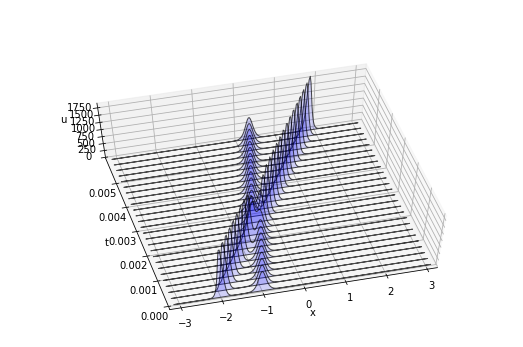

In [5]:
# Solve the KdV equation:
# u_t + u u_x + u_xxx = 0 on [-pi,pi] by FFT
# with integrating factor v = exp(-ik^3t)*uhat-

def program27(N,dt):
    # shortcuts
    sech = lambda x: 2/(np.exp(x)+np.exp(-x))
    fft = np.fft.fft
    ifft = np.fft.ifft

    # Set up grid and two-soliton initial data:
    x = (2*np.pi/N)*np.arange(-N/2,N/2)
    A = 25; B = 16;
    u = 3*A**2*sech(.5*(A*(x+2)))**2 + 3*B**2*sech(.5*(B*(x+1)))**2;

    v = np.fft.fft(u)
    k = np.concatenate([np.arange(0,N/2),[0],np.arange(-N/2+1,0)])
    ik3 = 1j*k**3

    # Solve PDE and plot results:
    tmax = 0.006; nplt = np.floor((tmax/25)/dt); nmax = int(np.round(tmax/dt));
    udata = [u]; tdata = [0]
    for n in range(1,nmax+1):
        t = n*dt; g = -.5j*dt*k;
        # 4th order Runge-Kutta
        E = np.exp(dt*ik3/2); E2 = E**2;
        a = g*fft(np.real( ifft( v          ) )**2);
        b = g*fft(np.real( ifft( E*(v+a/2)  ) )**2);
        c = g*fft(np.real( ifft( E*v + b/2  ) )**2);
        d = g*fft(np.real( ifft( E2*v + E*c ) )**2);
        v = E2*v + (E2*a + 2*E*(b+c) + d)/6;
        if n % nplt == 0:
            u = np.real(ifft(v))
            udata.append(u); tdata.append(t)
    waterfall(x,tdata,udata)

program27(N=256,dt=.4/256**2)

## 10.2. Rerun Program 27 with the time step increased from $0.4N^{-2}$ to $0.45N^{-2}$. Comment on the resulting plot. Can you explain this effect with reference to stability regions?

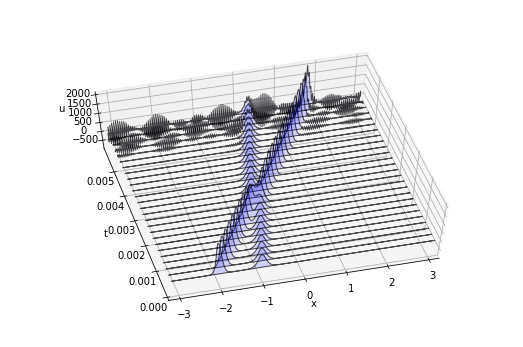

In [6]:
program27(N=256,dt=.427455/256**2)

Se puede observar que para este valor de $\Delta t$ la inestabilidad a penas comienza a manifestarse.

/usr/lib/python3/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in square
/usr/lib/python3/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in multiply


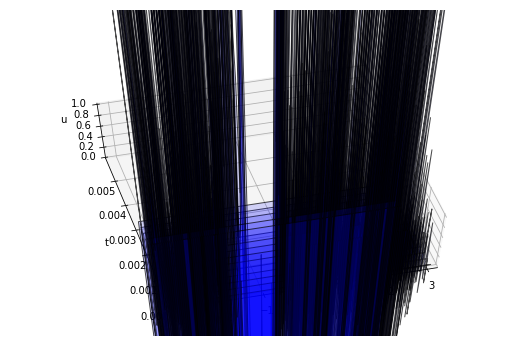

In [7]:
try: program27(N=256,dt=.45/256**2)
except: pass

Se puede ver que los errores aumentan mucho más con un $\Delta_t >= 6.866·10^{-6}$.

Siguiendo la *rule of thumb* señalada en el libro, para que los errores no se amplifiquen de manera indefinida cuando se discretiza una EDP usando una diferencia finita en el tiempo, es necesario que:

> Los valores propios del operador de discretización espacial, multiplicados por $\Delta t$ estén ubicados dentro de la región de estabilidad de la fórmula para realizarlos *time-steps*.

Lo que sucede cuando $\Delta t > 0.427455 N^{-2}$ es que los errores se comienzan a amplificar con cada salto en el tiempo. Esto ha de deberse a que en este punto algunos valores propios del operador de discretización espacial (multiplicado por $\Delta t$) escapa de la región de estabilidad del operador de discretización temporal, en este caso Runge-Kutta 4 con el factor de integración.

## Conclusiones

* Al resolver una EDP que depende del tiempo es importante usar un time-step suficientemente bajo para asegurar la estabilidad numérica de la simulación.

* Hay que tener presente que los valores de $\Delta t$ para los que la simulación es estable dependen de la magnitud del valor que adquieren las derivadas de la solución $u$ en la EDP (pues estos afectan los valores propios), y por lo tanto un código podría pasar a ser inestable si modificamos la ecuación manteniendo el time-step.

* De la lectura del libro: En el caso de que hayan derivadas temporales de mayor orden, los valores propios del operador de discretización espacial se multiplican por $\Delta t$ elevado al orden, lo que significa que se permiten time-steps mucho menores.

## Referencias

* Trefethen, L. N. (2000). Spectral methods in MATLAB (Vol. 10). Siam.

---
# {ii} From the textbook: Spectral Methods in MatLab, by Lloyd N. Solve exercise: 10.5.
---

## 10.5. Chebyshev grids have a $O(N^{-2})$ spacing near the boundaries. Therefore, it is sometimes said, it is obvious that an explicit Chebyshev spectral method for a hyperbolic PDE such as $u_t = u_x$ must require time steps of size $O(N^{-2})$, "because of the CFL (Courant-Friedrichs-Lewy) restriction" [RiMo67]. Explain why this argument is invalid.

La condición CFL surge bajo el supuesto de que se tiene un operador de discretización espacial con $\Delta x$ constante, pero una regla más general indica que:
> El método de las líneas [correspondiente a resolver un sistema de ODE's acopladas utilizando un diferencia finita en el tiempo] es estable si los valores propios de el operador de discretización espacial multiplicado por $\Delta t$ se encuentran dentro de la región de estabilidad de la fórmula para realizar los *time-steps*.

(El libro señala si que esta es una *rule of thumb* y a veces puede fallar cuando las matrices de discretización están lejos de ser normales, pero generalmente entrega buenas predicciones).

Supongamos que nuestra aproximación $U(t)$ de la solución $V(t)$ de una EDP está relacionada con esta por:
$$
V(t) = U(t) + E(t)
$$
donde $E(t)$ corresponde al error.

Y que la EDP se puede escribir de la siguiente forma al aplicar una discretización espacial:
$$
\frac{d V}{d t} = A V + b \,.
$$
Reemplazando utilizando la relación entre $V$ y $U$:
$$
\frac{d U}{d t} + \frac{d E}{d t} = A U + A E + b \,,
$$
y cómo vamos a estar utilizando:
$$
\frac{d U}{d t} = A U + b
$$
para actualizar $U$, podemos restar esta igualdad:
\begin{align}
\frac{d U}{d t} + \frac{d E}{d t} &= A U + A E + b
\\ \frac{d E}{d t} &= A E \,.
\end{align}
Nos interesa entonces que los valores propios del operador $A$ se encuentren dentro de la región de la fórmula de la discretización temporal que utilizemos, para que los errores no crezcan indefinidamente con el tiempo.

Al discretizar la ecuación anterior en el tiempo, veremos que el crecimiento del error será multiplicado por $\Delta t$ (denominador en la fórmula de discretización temporal). Si nuestro operador $A$ incluye diferencias finitas (espaciales) de primer orden, podemos esperar que sus eigenvalores sean proporcionales a $\frac{v}{\Delta x}$, de ahí tenemos que asegurar que:
$$
\Delta t \frac{|v|}{\Delta x} < 1 \,.
$$
donde $v(t,U)$ es el factor que multiplica $v_x$ en la EDP.


Sin embargo, si usamos métodos espectrales en vez de diferencias finitas en el espacio, este $\frac{1}{\Delta x}$ no entra en juego directamente, y tenemos que enfocarnos en los eigenvalores $\lambda_i$ del operador de diferenciación espectral:
$$
\Delta t |v| \lambda_i < 1, \qquad \forall i.
$$

## Conclusión

* La restricción CFL, pese a ser una buena *rule-of-thumb* no sirve para todos los casos, pues no se aplica cuando utilizamos una discretización espectral en vez de diferencias finitas. 


## Referencias

* Trefethen, L. N. (2000). Spectral methods in MATLAB (Vol. 10). Siam.
* https://web.mit.edu/16.90/BackUp/www/pdfs/Chapter14.pdf

---
# {iii} From the textbook: Spectral Methods in MatLab, by Lloyd N. Solve exercise: 10.6.
---

## 10.6 The $KdV$ equation (10.3) is closely related to the *Burgers equation*, $u_t + (u^2)_x = \epsilon u_{xx}$, where $\epsilon > 0$ is a constant [Whi75]. Modify Program 27 to solve this equation for $\epsilon = 0.25$ by Fourier spectral method on $[-\pi,\pi]$ with an integrating factor. Take $u(x,0)$ equal to $sin^2(x)$ in $[-\pi,0]$ and to zero in $[0,\pi]$, and produce plots at times $0, \frac{1}{2}, 1, \dots, 3$, with a sufficiently small time step, for $N = 64$,$128$, and $256$. For $N=256$, how small a value of $\epsilon$ can you take without obtaining unphysical oscillations?

Comenzamos modificando la ecuación:
\begin{align*}
u_t + (u^2)_x &= \epsilon u_{xx} &\big/ -\epsilon u_{xx}
\\ u_t + (u^2)_x - \epsilon u_{xx} &= 0 &\big/ F(\cdot)
\\ \hat{u_t} + ik \hat{(u^2)} + k^2 \epsilon \hat{u} &=0 & \big/ \cdot e^{k^2 \epsilon t}
\\ e^{k^2 \epsilon t}\hat{u_t} + ik e^{k^2 \epsilon t} \hat{(u^2)} + k^2 \epsilon e^{k^2 \epsilon t} \hat{u} &=0 \,.
\end{align*}
Si hacemos $\hat{U} = e^{k^2\epsilon t} \hat{u}$ tenemos que:
$$
\hat{U_t} = k^2 \epsilon e^{k^2\epsilon t}\hat{u} + e^{k^2\epsilon t}\hat{u_t} \,.
$$
Resulta:
\begin{align*}
\hat{U_t} + ik e^{k^2 \epsilon t} \hat{(u^2)} &= 0
\\ \hat{U_t} + ik e^{k^2 \epsilon t} 
F \left( \left( F^{-1}(e^{-k^2\epsilon t} \hat{U}) \right)^2 \right) &= 0
\end{align*}

Ahora, la fórmula para obtener $\hat{U}_{n+1}$ usando RK4 es:
\begin{align}
\hat{U}_{n+1} &= \hat{U}_{n} + \frac{1}{6}(k_1+2k_2+2k_3+k_4) 
\\ k_1 &= f(t_n,\hat{U}_n)
\\ k_2 &= f(t_n+\tfrac{\Delta t}{2},\hat{U}_n+\tfrac{k_1}{2})
\\ k_3 &= f(t_n+\tfrac{\Delta t}{2},\hat{U}_n+\tfrac{k_2}{2})
\\ k_4 &= f(t_n+\Delta t,\hat{U}_n+k_3)
\end{align}
con
\begin{align}
f(t,\hat{U}) &= -ik e^{k^2 \epsilon t} 
F \left( \left( F^{-1}(e^{-k^2\epsilon t} \hat{U}) \right)^2 \right) \,.
\end{align}
Por comodidad, definimos:
$$
g(\hat{u}) = -ik F \left( \left( F^{-1}(\hat{u}) \right)^2 \right) \,.
$$
notando que:
<!-- $$
g(\hat{u}) = e^{-k^2\epsilon t} f(t,e^{k^2\epsilon t} \hat{u}) 
$$ -->
$$
f(t,\hat{u}) = e^{k^2\epsilon t} g(e^{-k^2\epsilon t} \hat{u}) \,.
$$

Haciendo
\begin{align}
   a &= e^{-k^2\epsilon t_n} k_1
\\ b &= e^{-k^2\epsilon (t_n + \tfrac{\Delta t}{2})} k_2
\\ c &= e^{-k^2\epsilon (t_n + \tfrac{\Delta t}{2})} k_3
\\ d &= e^{-k^2\epsilon (t_n + \Delta t)} k_4
\end{align}

Los términos de RK4 quedan:
\begin{align}
k_1 &= \Delta t\, f(
        t_n,
        e^{k^2\epsilon t_n}\hat{u}_n)
    \\ &= e^{k^2\epsilon t_n} \underbrace{\Delta t\, g(
        \hat{u}_n
    )}_{a}
\\ k_2 &= \Delta t \, f \left(
        t_n+\tfrac{\Delta t}{2},
        e^{k^2\epsilon t_n}\hat{u}_n+\tfrac{k_1}{2}
    \right) 
    \\ &= \Delta t \, f\left(
        t_n+\tfrac{\Delta t}{2},
        e^{k^2\epsilon t_n}(\hat{u}_n+\tfrac{a}{2})
    \right)
    \\ &= e^{k^2\epsilon (t_n + \tfrac{\Delta t}{2})} \underbrace{\Delta t \, g\left(
        e^{-k^2 \epsilon \tfrac{\Delta t}{2}}( \hat{u}_n+\tfrac{a}{2} )
    \right)}_{b}
\\ k_3 &= \Delta t \, f\left(
        t_n+\tfrac{\Delta t}{2},
        e^{k^2\epsilon t_n}\hat{u}_n+ \tfrac{k_2}{2}
    \right)
    \\ &= \Delta t \, f\left(
        t_n+\tfrac{\Delta t}{2},
        e^{k^2\epsilon t_n}\left(\hat{u}_n+ e^{k^2\epsilon \tfrac{\Delta t}{2}}\tfrac{b}{2}\right)
    \right)
    \\ &= e^{k^2\epsilon (t_n + \tfrac{\Delta t}{2})} \underbrace{\Delta t \, g\left(
        e^{-k^2 \epsilon \tfrac{\Delta t}{2}} \left( \hat{u}_n+ e^{k^2\epsilon \tfrac{\Delta t}{2}}\tfrac{b}{2} \right)
    \right)}_{c}
\\ k_4 &= \Delta t \, f(
        t_n+\Delta t,
        e^{k^2\epsilon t_n}\hat{u}_n+k_3)
    \\ &= e^{k^2\epsilon (t_n + \Delta t)} \underbrace{\Delta t \, g\left( e^{-k^2 \epsilon \Delta t} \left(
        \hat{u}_n+e^{k^2\epsilon (t_n + \tfrac{\Delta t}{2})} c
    \right) \right)}_{d} \quad ,
\end{align}

y la fórmula para calcular $\hat{U}_{n+1}$, expresada en términos de $a,b,c,d$ y finalmente $\hat{u}$ resulta:
\begin{align}
\hat{U}_{n+1} &= \hat{U}_{n} + \frac{1}{6} \left(
e^{k^2\epsilon t_n} a
+ 2 e^{k^2\epsilon (t_n+\tfrac{\Delta t}{2})} b
+ 2 e^{k^2\epsilon (t_n+\tfrac{\Delta t}{2})} c
+ e^{k^2\epsilon (t_n + \Delta t)} d
\right)
\\ \hat{U}_{n+1} 
   &= \hat{U}_{n} + e^{k^2\epsilon t_n} \frac{1}{6}\left( 
   a
   + 2 e^{k^2\epsilon \tfrac{\Delta t}{2}} b
   + 2 e^{k^2\epsilon \tfrac{\Delta t}{2}} c
   + e^{k^2\epsilon \Delta t} d
\right)
\\ e^{k^2\epsilon (t+\Delta t)} \hat{u}_{n+1} 
   &= e^{k^2\epsilon t} \hat{u}_{n} + e^{k^2\epsilon t_n} \frac{1}{6} \left( 
   a
   + 2 e^{k^2\epsilon \tfrac{\Delta t}{2}} b
   + 2 e^{k^2\epsilon \tfrac{\Delta t}{2}} c
   + e^{k^2\epsilon \Delta t} d
\right) & \big/ \cdot e^{-k^2\epsilon (t+\Delta t)}
\\ \hat{u}_{n+1} 
   &= e^{-k^2\epsilon \Delta t} \hat{u}_{n} + \frac{1}{6} \left( 
   e^{-k^2\epsilon \Delta t} a
   + 2 e^{-k^2\epsilon \tfrac{\Delta t}{2}} b
   + 2 e^{-k^2\epsilon \tfrac{\Delta t}{2}} c
   + d
\right)
\end{align}

## Program 27 (modified for exercise 10.5)

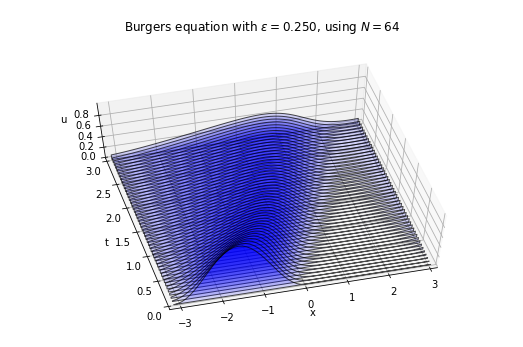

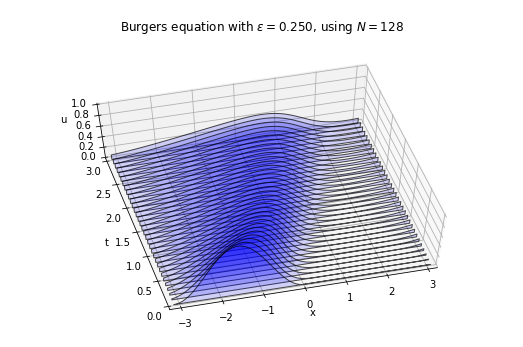

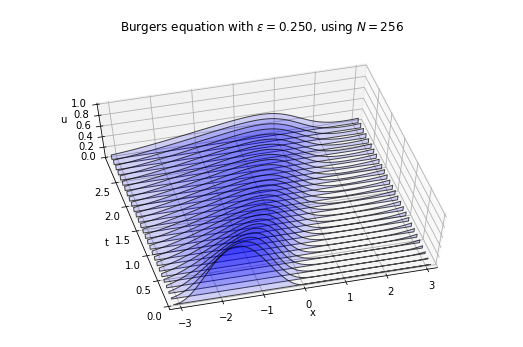

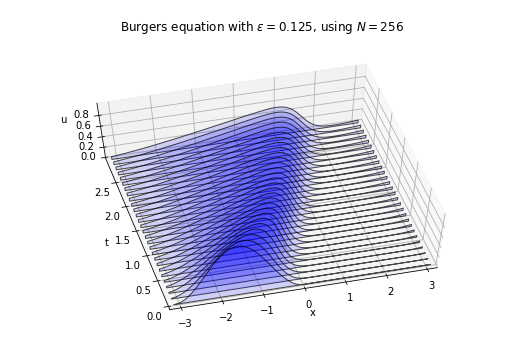

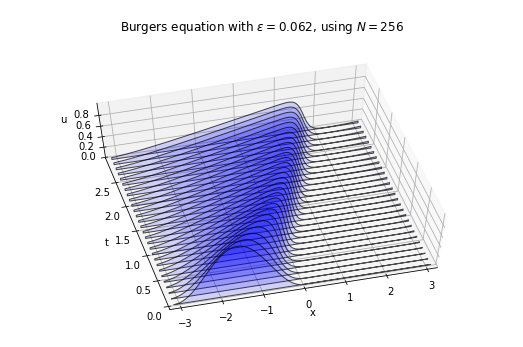

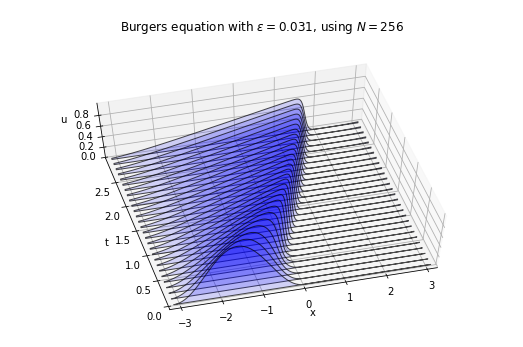

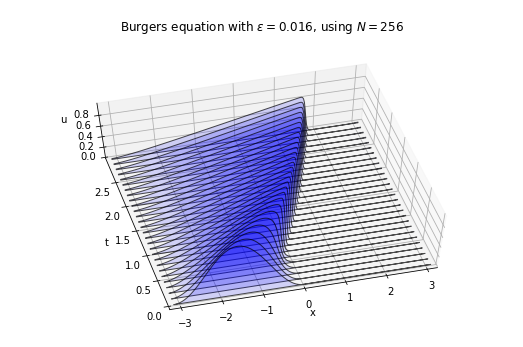

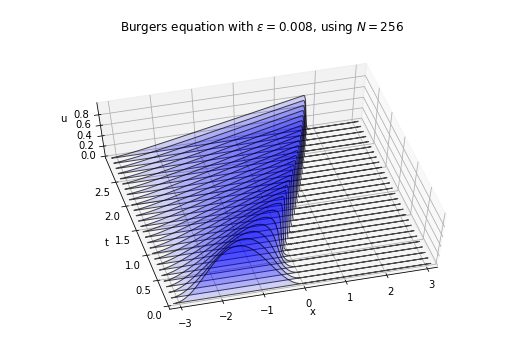

In [8]:
# Solve the Burgers equation:
# u_t + (u^2)_x + = epsilon u_xx on [-pi,pi] by FFT
# with integrating factor exp(k^2 epsilon t)*uhat

def program27_105(N,dt,epsilon):
    # shortcuts
    fft = np.fft.fft
    ifft = np.fft.ifft

    # Set up grid and initial data:
    x = (2*np.pi/N)*np.arange(-N/2,N/2)
    A = 25; B = 16;
    u = np.sin(x)**2
    u[x>=0] = 0
    
    v = np.fft.fft(u)
    k = np.concatenate([np.arange(0,N/2),[0],np.arange(-N/2+1,0)])
    
    k2ep = k**2*epsilon

    # Solve PDE and plot results:
    tmax = 3; nplt = np.floor((tmax/25)/dt); nmax = int(np.round(tmax/dt));
    udata = [u]; tdata = [0]
    for n in range(1,nmax+1):
        t = n*dt; g = -dt*1j*k;
        # 4th order Runge-Kutta
        mE = np.exp(-dt*k2ep/2); mE2 = mE**2 
        a = g*fft(np.real( ifft( v            ) )**2);
        b = g*fft(np.real( ifft( mE*(v + a/2) ) )**2);
        c = g*fft(np.real( ifft( mE*v + b/2   ) )**2);
        d = g*fft(np.real( ifft( mE2*v + mE*c ) )**2);
        v = mE2*v + (mE2*a + 2*mE*(b+c) + d)/6.0;
        if n % nplt == 0:
            u = np.real(ifft(v))
            udata.append(u); tdata.append(t)
    waterfall(x,tdata,udata,title="Burgers equation with $\epsilon=%.3f$, using $N=%d$"%(epsilon,N))

for nn in (64,128,256):
    program27_105(N=nn,dt=4/nn,epsilon=0.25)
for eps in [2**-x for x in range(3,8)]:
    program27_105(N=256,dt=4/256,epsilon=eps)

Valores $\epsilon < 0.008$ generan oscilaciones que resultan en errores numéricos. Podemos ver que en ese punto se forma una discontinuidad (pendiente $\rightarrow \infty$) al llegar a $t=3$.

## Conclusiones

* El método de los *integrating factors* consiste en multiplicar la ecuación por un factor conveniente de manera que un término inconviente para la estabilidad numérica de la EDP se pueda combinar con el término que contiene la derivada temporal, para formar la que sería la derivada temporal de otra variable. Y así, realizando un cambio de variable, obtener una EDP equivalente sin el término inconviente (*stiff*).
* El espacio de Fourier es una alternativa simple para trabajar EDP con derivadas espaciales.

## Referencias

* Trefethen, L. N. (2000). Spectral methods in MATLAB (Vol. 10). Siam.

---
# {iv} Explain the problem solved, explain the algorithm and reproduce the outputs of programs: 34, 35 and 37 from the textbook: Spectral Methods in MatLab, by Lloyd N. Trefethen.
---

# Program 34

El programa 34 resuelve la ecuación de Allen Cahn o ecuación biestable:
$$
u_t = \epsilon u_{xx} + u - u^3
$$
Esta ecuación alcanza el equilibrio en $u=1$, $u=-1$ y $u=0$, aunque el último es inestable, en puntos donde la solución se acerca a $-1$ o $1$, esta es atraída con el tiempo.


La derivada $u_{xx}$ se realiza multiplicando por la derivada de diferenciación espectral $D$ al cuadrado. El avance en el tiempo se realiza por medio de un simple método de Euler.

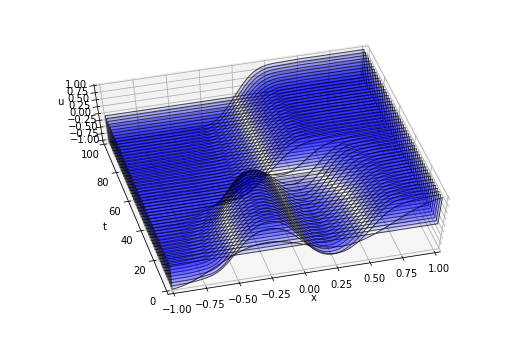

In [9]:
def program34(N=20,tmax=100,tplot=2):
    D,x = cheb(N); D2 = np.dot(D,D) # use full-size matrix
    D2[[0,N],:] = 0 # for convenience
    eps = 0.01; dt = min(0.01,50*N**-4.0/eps);
    t = 0; v = 0.53*x + 0.47*np.sin(-1.5*np.pi*x)
    
    # Solve PDE
    nplots = round(tmax/tplot);
    plotgap = round(tplot/dt); dt = tplot/plotgap;
    xx = np.arange(-1,1.001,0.025);
    vv = np.polyval(np.polyfit(x,v,N),xx)
    
    plotdata = np.vstack([[vv], np.zeros((nplots,len(xx)))]);
    tdata = [t];
    for i in range(1,nplots+1):
        for n in range(1,plotgap+1):
            t = t+dt
            v = v + dt*(eps*np.dot(D2,v-x) + v - v**3);
        vv = np.polyval(np.polyfit(x,v,N),xx);
        plotdata[i,:] = vv; tdata.append(t)
    
    # Plot results
    waterfall(xx,tdata,plotdata)

program34()

# Program 35

El programa 35 aborda la misma ecuación, pero considerando condiciones de borde más complicadas:
$$
u(-1,t) = 0, \qquad u(1,t) = 1+\sin^2(t/5) \,.
$$
Para cumplir con estas condiciones de borde, se utiliza la idea de añadir ecuaciones que fuercen estas condiciones (esto es más versátil en contraste con utilizar interpoladores que las satisfagan), como se trata de condiciones de borde de Dirichlet, basta con asignar los valores `v[0]` y `v[-1]` en cada *time-step*, al que corresponde dada la condición.

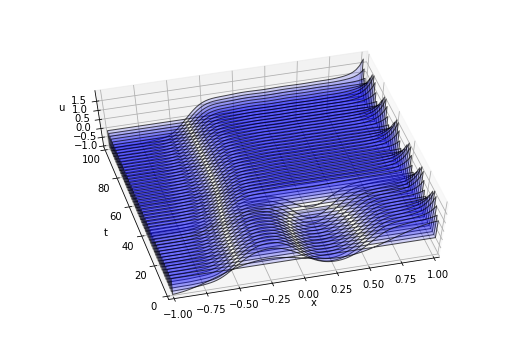

In [10]:
def program35(N=20,tmax=100,tplot=2):
    D,x = cheb(N); D2 = np.dot(D,D) # use full-size matrix
    D2[[0,N],:] = 0 # for convenience
    eps = 0.01; dt = min(0.01,50*N**-4.0/eps);
    t = 0; v = 0.53*x + 0.47*np.sin(-1.5*np.pi*x)
    
    # Solve PDE
    nplots = round(tmax/tplot);
    plotgap = round(tplot/dt); dt = tplot/plotgap;
    xx = np.arange(-1,1.001,0.025);
    vv = np.polyval(np.polyfit(x,v,N),xx)
    
    plotdata = np.vstack([[vv], np.zeros((nplots,len(xx)))]);
    tdata = [t];
    for i in range(1,nplots+1):
        for n in range(1,plotgap+1):
            t = t+dt
            v = v + dt*(eps*np.dot(D2,v-x) + v - v**3)
            v[0] = 1 + np.sin(t/5)**2
            v[-1] = -1
        vv = np.polyval(np.polyfit(x,v,N),xx);
        plotdata[i,:] = vv; tdata.append(t)
    
    # Plot results
    waterfall(xx,tdata,plotdata)

program35()

# Program 37

Para este programa se considera una ecuación diferente, en primer lugar hay dos dimensiones espaciales:
$$
u_{tt} = u_{xx} + u_{yy}, \qquad -3<x<3, \qquad -1<y<1 \,,
$$
en segundo, hay condiciones de borde del tipo Neumann y de dominio periódico:
$$
u_y(x,\pm 1,t) = 0, \qquad u(-3,y,t) = u(3,y,t)
$$

El *time-step* se realiza utilizando la *leap frog formula*, similar al método de Euler, pero también utiliza el valor de la solución en la iteración anterior.

El problema se aproxima utilizando una discretización de Fourier en el eje X (puesto que se trata de un dominio periódico), mientras que en el eje Y se utiliza una discretización de Chebyshev.

Notar que `D2y` es la matriz de diferenciación al cuadrado en Y, y `D2x` es la matriz de diferenciación al cuadrado en X; puesto que esta última opera sobre las filas en la matriz que contiene el estado $vv$ en vez de las columnas, se debe multiplicar por la izquierda.


Las condiciones de borde periodicas se aseguran simplemente por el interpolador (Fourier). Por otro lado, asegurar las condiciones de borde en $|y|=1$ requiere un tratamiento especial.

En el código, cada columna de la matriz `BC` (de dimensiones $2 \times (\texttt{Ny}-1)$) representa una matriz que al multiplicarse por `vv` permite obtener valores en los extremos $|y|=1$ que cumplen con la condición de borde.

t=0.00


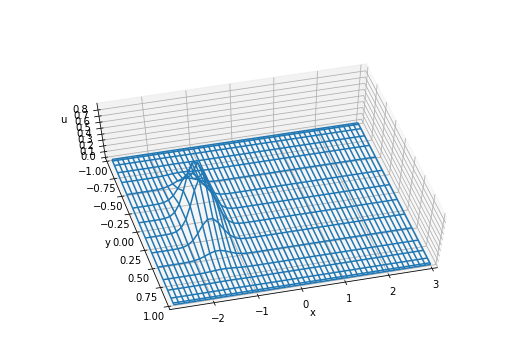

t=2.00


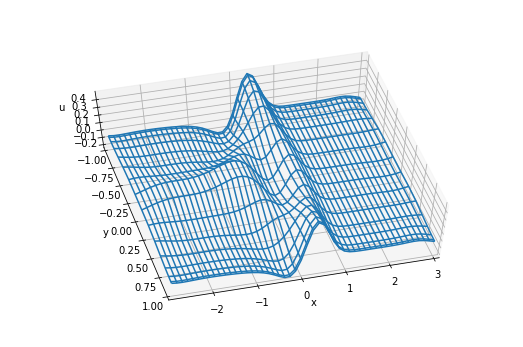

t=4.00


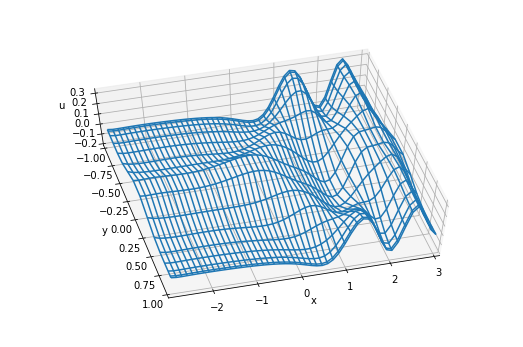

In [21]:
def program37():
    # 2D "wave tank" with Neumann BCs for |y|=1
    
    # x variable in [-A,A], Fourier:
    A = 3; Nx = 50; dx = 2*A/Nx; x = -A+dx*np.arange(1,Nx+1) #.T
    arr = .5*(-1)**np.arange(2,Nx+1)/np.sin((np.pi*dx/A)*np.arange(1,Nx)/2)**2
    D2x = (np.pi/A)**2*scipy.linalg.toeplitz(np.hstack([[-1/(3*(dx/A)**2)-1/6],arr]));
    
    # y variable in [-1,1], Chebyshev:
    Ny = 15; Dy,y = cheb(Ny); D2y = np.dot(Dy,Dy);
    aaa = -Dy[[0,Ny]][:,[0,Ny]]
    bbb = Dy[[0,Ny]][:,1:Ny]
    BC = np.linalg.solve(aaa,bbb);
    
    # Grid and initial data:
    dt = 5/(Nx+Ny**2); plotgap = round(2/dt); dt = 2/plotgap;
    xx,yy = np.meshgrid(x,y)
    vv = np.exp(-8*((xx+1.5)**2+yy**2))
    vvold = np.exp((-8*((xx+dt+1.5)**2+yy**2)))
    
    # Time-stepping by leap frog formula:
    for n in range(2*plotgap+1):
        t = n*dt
        if (n+.5)%plotgap<1:
            print("t=%.2f"%t)
            waterfall(x,y,vv,spacial2d=True)
        vvnew = 2*vv - vvold + dt**2*(np.dot(vv,D2x)+np.dot(D2y,vv))
        vvold = vv; vv = vvnew
        vv[[0,Ny]] = np.dot(BC,vv[1:Ny,:]) # Neumann BCs for |y|=1
program37()

## Conclusiones

* Para cumplir con las condiciones de borde de una EDP, se puede utilizar un interpolador que asegure esto; para casos más complejos se deben agregar ecuaciones al problema discreto que las fuercen.
* Para lograr esto se pueden realizar cada *time-steps* utilizando operadores diferenciales que no consideran las condiciones de borde (como las matrices de diferenciación espectral), y luego corregir los valores en los bordes a un valor dado por las ecuaciones adiconales.

## Referencias

* Trefethen, L. N. (2000). Spectral methods in MATLAB (Vol. 10). Siam.

# Program 36 (extra)

/usr/lib/python3/dist-packages/scipy/interpolate/_fitpack_impl.py:975: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=3,3 nx,ny=30,29 m=625 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


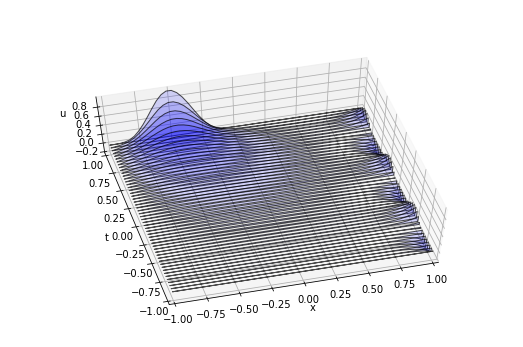

In [12]:
def program36(N=24):
    # Set up grid and 2D Laplacian, boundary points included:
    D,x = cheb(N); y = x
    xx,yy = np.meshgrid(x,y)
    D2 = np.dot(D,D)
    I = np.eye(N+1); L= np.kron(I,D2) + np.kron(D2,I)
    # Impose boundary conditions by replacing appropriate rows of L
    bi = np.flatnonzero(np.logical_or(np.abs(xx)==1,np.abs(yy)==1)) # boundary indexes (i)
    bx = np.nonzero(np.logical_or(np.abs(xx)==1,np.abs(yy)==1)) # boundary indexes (x,y)
    L[bi,:] = 0
    L[bi,bi] = 1 # not sure
    rhs = np.zeros(((N+1)**2,1))
    rhs[bi,0] = (yy[bx]==1)*(xx[bx]<0)*np.sin(np.pi*xx[bx])**4 + \
        .2*(xx[bx]==1)*np.sin(3*np.pi*yy[bx])
    # Solve Laplace equation, reshape to 2D, and plot
    u = np.linalg.solve(L,rhs)
    uu = u.reshape((N+1,N+1))
    xx,yy = np.meshgrid(x,y)
    f = scipy.interpolate.interp2d(xx,yy,uu,'cubic');
    xxx,yyy = np.arange(-1,1.0001,.04), np.arange(-1,1.0001,.04);
    uuu = f(xxx,yyy)
    waterfall(xxx,yyy,uuu)
    
    
program36()

---
# {v} From the textbook: Spectral Methods in MatLab, by Lloyd N. Solve exercise: 13.3.
---

## 13.3. Modify Program 19 (p. 82) to solve $u_{tt} = u_{xx}$ as before but with initial and boundary conditions $$ u(x,0) = 0, \quad u_x(-1,t)=0, \quad u(1,t) = \sin(10t) \,. $$ Produce an attractive plot for of the solution for $0 \leq t \leq 5$.

El programa 19 originalmente resuelve la ecuación de onda utilizando la *leap frog formula*, la diferenciación espacial se logra utilizando la transformada de Fourier en la función `chebfft`.

In [28]:
def program19_mod(N=80):
    # Time-stepping by leap frog formula:
    x = np.cos(np.pi*np.arange(N+1)/N); dt = 8.0/N**2
    v = x*0; vold = x*0
    tmax = 5; tplot=.075
    plotgap = round(tplot/dt); dt = tplot/plotgap
    nplots = round(tmax/tplot)
    plotdata = np.zeros((nplots+1,N+1))
    plotdata[0] = v
    tdata = [0]
    for i in range(nplots):
        for j in range(plotgap):
            t = (i*plotgap+j)*dt
            v2 = chebfft(v)
            v2[-1] = 0              # u_x(-1,t) = 0
            w = chebfft(v2)
            vnew = 2*v - vold + dt**2*w
            vnew[-1] = vnew[-2]     # u_x(-1,t) = 0
            vnew[0] = np.sin(10*t) # u(1,t) = sin(10t)
            vold = v; v = vnew
        plotdata[i+1] = v; tdata.append(t)
    waterfall(x,tdata,plotdata,maxlines=32,elev=65,azim=180+40)

Para forzar la condición de Neumann simplemente se hace `v2[-1]=0` tras utilizar `chebfft` la primera vez. Aunque esto es suficiente dado que las condiciones iniciales cumplen con esta restricción, también se asegura que la condición se mantenga en el tiempo por medio de hacer `vnew[-1] = vnew[-2]`.

*Nota: `chebfft` fue implementado al principio del notebook.*

Una alternativa sería calcular la matriz de diferenciación `D` y el cuadrado de la misma
`D2 = np.dot(D,D)` y luego igualar `D2[N] = D[N]` de la misma manera que se hace en el Programa 33 del libro.

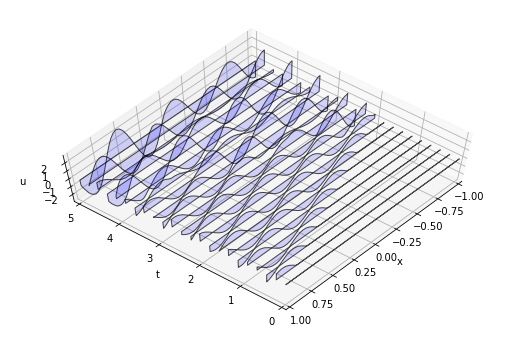

In [29]:
program19_mod()

Del gráfico se puede ver que la función oscila en $x=1$ y una vez las ondas llegan a $x=-1$, estas rebotan acomplándose con las ondas que van de ida. 

## Conclusiones

* *Se concluye lo mismo que en la pregunta anterior.*
* Algunas ecuaciones que insertemos para forzar las condiciones de borde pueden omitirse o, si se trata de asignaciones, hacerse sólo en los resultados parciales que afectan al actualizar la solución, pero no en la solución directamente, si es que las condiciones iniciales lo permiten. Por ejemplo en este problema se vio que hacer `v2[-1] = 0` es suficiente para lograr la solución dada y `vnew[-1] = vnew[-2]` es innecesario, puesto que esto se cumple en las condiciones iniciales y no debería cambiar significativamente conforme se avanza en el tiempo.
* Las condiciones de borde pueden determinar completamente la evolución de una solución en el tiempo, tal es el caso en este problema.

## Referencias

* Trefethen, L. N. (2000). Spectral methods in MATLAB (Vol. 10). Siam.